In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/f_mnist/logs/garipov/decomposed/")

In [3]:
ylim = (0.7,1.0)

In [4]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 250


In [5]:
# from datetime import datetime

# dts = [datetime.fromtimestamp(int(x)) for x in folders]
# print(max(dts))
# print(min(dts))
# print(min(folders))

In [6]:
from tddl.post_processing.path_utils import logdir_to_paths

paths = logdir_to_paths(logdir)

print(len(paths))

250


In [7]:
# baseline

baseline_path = Path("/bigdata/f_mnist/logs/garipov/baselines/1647955843/gar_18_dNone_128_sgd_l0.1_g0.1_w0.0_sTrue")
# baseline_model = torch.load(baseline_path / "cnn_best.pth")
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)
baseline_result

{'best_epoch': 66,
 'best_train_acc': 0.9791636363636363,
 'best_valid_acc': 0.9492,
 'best_valid_loss': 0.0016404973324388266,
 'test_acc': 0.9397,
 'test_loss': 0.0018576418459415435,
 'n_param': 556490,
 'model_name': 'gar_18_dNone_128_sgd_l0.1_g0.1_w0.0_sTrue'}

In [8]:
from tddl.post_processing.factorized_model import process_factorized_networks

# process_factorized_networks(paths, baseline_path)

/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [9]:
from tddl.post_processing.path_utils import paths_to_df

df = paths_to_df(paths)
print(len(df))
df.head()


250


name  nr  relative_norm_weight  scaled_norm_weight  diff_norm_weight  \
0  conv5   8              0.137097            0.000028          4.113379   
1  conv6  10              0.126594            0.000014          2.134515   
2  conv2   2              0.292474            0.000161          5.931450   
3  conv4   6              0.159686            0.000031          4.544441   
4  conv2   2              0.615756            0.000339         12.487696   

   layers factorization  rank  valid_acc  valid_acc_before_ft  n_param_fact  \
0       8            cp  0.75     0.9466               0.9478        520020   
1      10            cp  0.75     0.9492               0.9492        520020   
2       2        tucker   0.5     0.9478               0.9484        538325   
3       6            cp  0.75     0.9482               0.9474        520020   
4       2            cp   0.1     0.9448               0.8984        523406   

   test_acc      lr optimizer   norm_diff       norm_b      n_b  \
0    0.9374  0.0001       sgd    7.716044   363.930520   4608.0   
1    0.9391  0.0001       sgd    3.574205    60.104838   4608.0   
2    0.9383  0.0001       sgd  104.404582  1146.403785  50176.0   
3    0.9399  0.0001       sgd   11.156350   375.486152  21632.0   
4    0.9323  0.0001       sgd  229.319759  1146.403785  50176.0   

   relative_norm  scaled_norm  
0       0.021301     0.001674  
1       0.059740     0.000776  
2       0.091298     0.002081  
3       0.029868     0.000516  
4       0.201407     0.004570

In [10]:
df['rank'] = df['rank'].astype(float, copy=False)
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df['layer_fact'] = df['layers'].apply(str) + '-' + df['factorization'] 
df['layer_fact_rank'] = df['layers'].apply(str) + '-' + df['factorization'] + '-' + df['rank'].apply(str)
df.head()

name  nr  relative_norm_weight  scaled_norm_weight  diff_norm_weight  \
0  conv5   8              0.137097            0.000028          4.113379   
1  conv6  10              0.126594            0.000014          2.134515   
2  conv2   2              0.292474            0.000161          5.931450   
3  conv4   6              0.159686            0.000031          4.544441   
4  conv2   2              0.615756            0.000339         12.487696   

   layers factorization  rank  valid_acc  valid_acc_before_ft  ...  optimizer  \
0       8            cp  0.75     0.9466               0.9478  ...        sgd   
1      10            cp  0.75     0.9492               0.9492  ...        sgd   
2       2        tucker  0.50     0.9478               0.9484  ...        sgd   
3       6            cp  0.75     0.9482               0.9474  ...        sgd   
4       2            cp  0.10     0.9448               0.8984  ...        sgd   

    norm_diff       norm_b      n_b  relative_norm  scaled_norm   fact_rank  \
0    7.716044   363.930520   4608.0       0.021301     0.001674     cp-0.75   
1    3.574205    60.104838   4608.0       0.059740     0.000776     cp-0.75   
2  104.404582  1146.403785  50176.0       0.091298     0.002081  tucker-0.5   
3   11.156350   375.486152  21632.0       0.029868     0.000516     cp-0.75   
4  229.319759  1146.403785  50176.0       0.201407     0.004570      cp-0.1   

   fact_layers  layer_fact layer_fact_rank  
0         cp-8        8-cp       8-cp-0.75  
1        cp-10       10-cp      10-cp-0.75  
2     tucker-2    2-tucker    2-tucker-0.5  
3         cp-6        6-cp       6-cp-0.75  
4         cp-2        2-cp        2-cp-0.1  

[5 rows x 23 columns]

In [11]:
df['test_error'] = 1 - df.test_acc
df['valid_error_before_ft'] = 1 - df.valid_acc_before_ft
df['valid_error'] = 1 - df.valid_acc

df['log_test_error'] = np.log(df.test_error)
df['log_valid_error_before_ft'] = np.log(df.valid_error_before_ft)
df['log_valid_error'] = np.log(df.valid_error)

In [12]:
df = df.astype({
    'layers':"category",
    'fact_layers':"category",
    'layer_fact':"category",
    # 'layer_fact_rank':"category",
})

## Approximation error on the weights

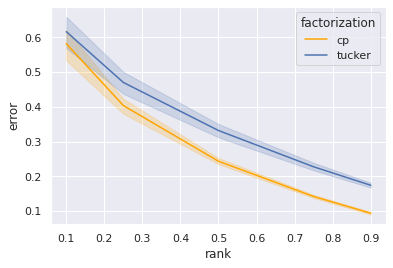

In [16]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
ax = sns.lineplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

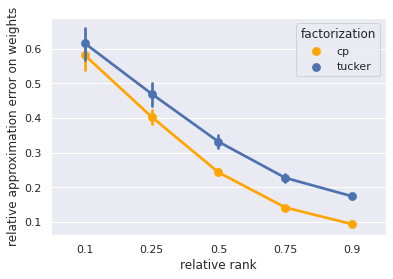

In [17]:
ax = sns.pointplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.set(xlabel='relative rank', ylabel='relative approximation error on weights')

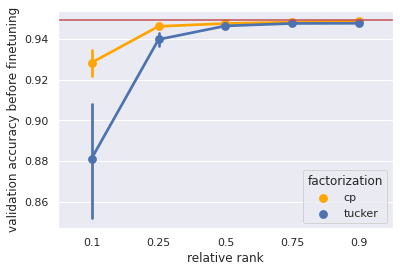

In [18]:
ax = sns.pointplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative rank', ylabel='validation accuracy before finetuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

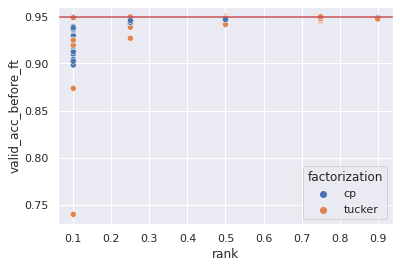

In [19]:
ax = sns.scatterplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="factorization",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

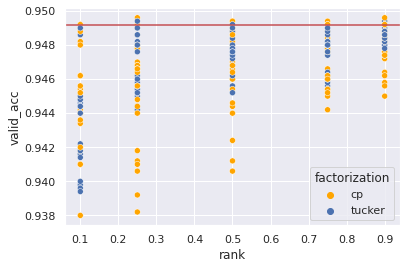

In [20]:
ax = sns.scatterplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

[Text(0.5, 0, 'relative rank'),
 Text(0, 0.5, 'validation accuracy after finetuning')]

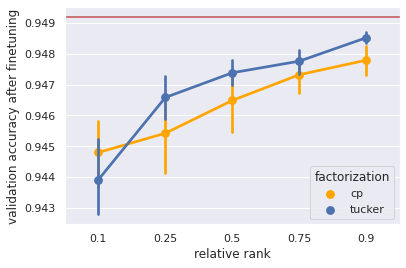

In [21]:
ax = sns.pointplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='validation accuracy after finetuning')
# ax.set(ylim=(0.865, 0.925))

[Text(0.5, 0, 'relative rank'), Text(0, 0.5, 'test accuracy after finetuning')]

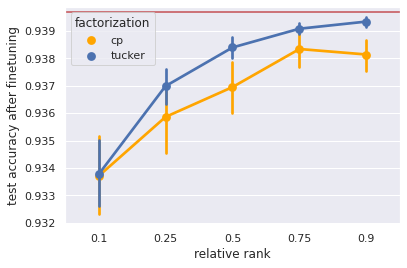

In [22]:
ax = sns.pointplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='test accuracy after finetuning')
# ax.set(ylim=(0.865, 0.925))

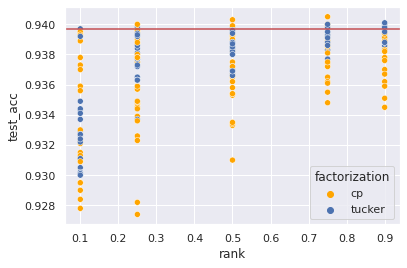

In [23]:
ax = sns.scatterplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['test_acc'], color='r')

In [24]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

In [25]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

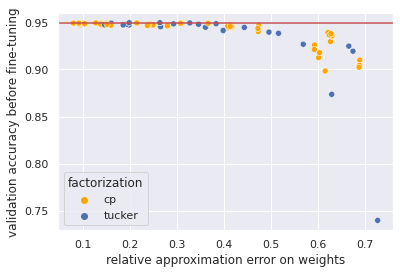

In [26]:
ax = sns.scatterplot(
    x="error", y="valid_acc_before_ft", 
    hue="factorization", 
    # style="factorization",
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy before fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

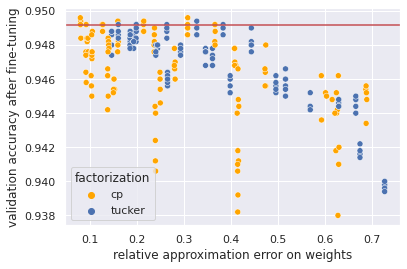

In [27]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

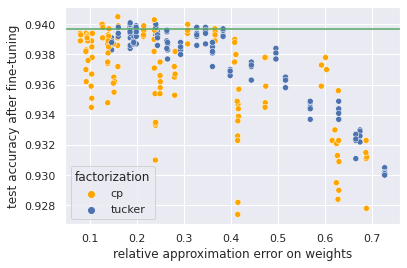

In [28]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))

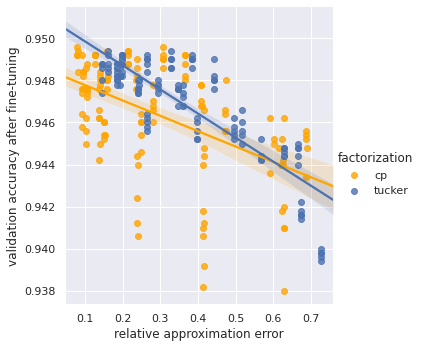

In [29]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')
# g.axhline(baseline_result['valid_acc'], color='g')

In [30]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

name  nr     error layers factorization  rank  valid_acc  \
0  conv5   8  0.137097      8            cp  0.75     0.9466   
1  conv6  10  0.126594     10            cp  0.75     0.9492   
2  conv2   2  0.292474      2        tucker  0.50     0.9478   
3  conv4   6  0.159686      6            cp  0.75     0.9482   
4  conv2   2  0.615756      2            cp  0.10     0.9448   

   valid_acc_before_ft  n_param_fact  test_acc      lr optimizer   norm_diff  \
0               0.9478        520020    0.9374  0.0001       sgd    7.716044   
1               0.9492        520020    0.9391  0.0001       sgd    3.574205   
2               0.9484        538325    0.9383  0.0001       sgd  104.404582   
3               0.9474        520020    0.9399  0.0001       sgd   11.156350   
4               0.8984        523406    0.9323  0.0001       sgd  229.319759   

        norm_b      n_b  relative_norm  scaled_norm   fact_rank fact_layers  \
0   363.930520   4608.0       0.021301     0.001674     cp-0.75        cp-8   
1    60.104838   4608.0       0.059740     0.000776     cp-0.75       cp-10   
2  1146.403785  50176.0       0.091298     0.002081  tucker-0.5    tucker-2   
3   375.486152  21632.0       0.029868     0.000516     cp-0.75        cp-6   
4  1146.403785  50176.0       0.201407     0.004570      cp-0.1        cp-2   

  layers_fact  
0        8-cp  
1       10-cp  
2    2-tucker  
3        6-cp  
4        2-cp

In [31]:
# g = sns.lmplot(x="error", y="test_acc", 
#    hue="fact_rank", 
#    data=df,
#    truncate=False, 
#    # palette=['orange','b'],
# )
# g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
# g.set(ylim=(0.935, 0.945))

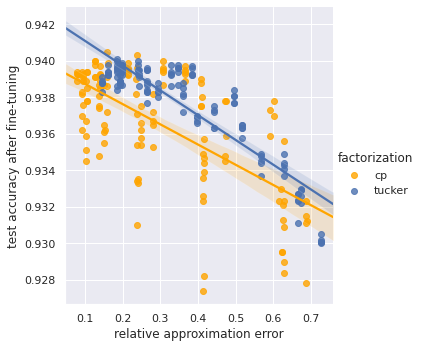

In [32]:
ax = sns.lmplot(x="error", y="test_acc", 
   hue="factorization", 
   data=df,
   # logistic=True,
   truncate=False, 
   palette=['orange','b'],
)
ax.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')


In [33]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

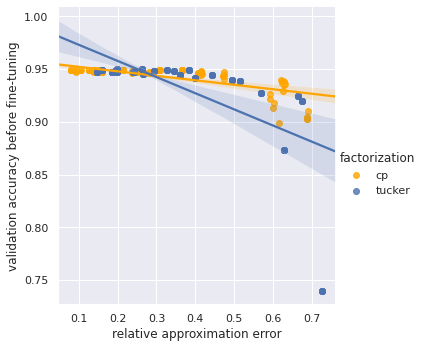

In [34]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [35]:
df_layers = pd.DataFrame(results)
df_layers['rank'] = df_layers['rank'].astype(float, copy=False)
df_layers = df_layers.loc[df_layers['rank'] == 0.5]
df_layers

name  nr     error  layers factorization  rank  valid_acc  \
2    conv2   2  0.292474       2        tucker   0.5     0.9478   
9    conv4   6  0.280843       6            cp   0.5     0.9470   
26   conv4   6  0.279353       6            cp   0.5     0.9478   
29   conv6  10  0.213963      10            cp   0.5     0.9494   
32   conv3   4  0.248733       4            cp   0.5     0.9460   
34   conv5   8  0.360534       8        tucker   0.5     0.9474   
40   conv6  10  0.213242      10            cp   0.5     0.9488   
46   conv3   4  0.345714       4        tucker   0.5     0.9478   
49   conv6  10  0.213890      10            cp   0.5     0.9488   
52   conv6  10  0.263183      10        tucker   0.5     0.9490   
66   conv4   6  0.280860       6            cp   0.5     0.9460   
67   conv6  10  0.213501      10            cp   0.5     0.9492   
73   conv5   8  0.360534       8        tucker   0.5     0.9468   
87   conv3   4  0.345714       4        tucker   0.5     0.9476   
89   conv4   6  0.398233       6        tucker   0.5     0.9460   
90   conv4   6  0.279933       6            cp   0.5     0.9466   
94   conv2   2  0.235996       2            cp   0.5     0.9476   
100  conv2   2  0.235910       2            cp   0.5     0.9480   
119  conv2   2  0.236526       2            cp   0.5     0.9482   
123  conv2   2  0.292474       2        tucker   0.5     0.9476   
124  conv6  10  0.213977      10            cp   0.5     0.9494   
130  conv5   8  0.360534       8        tucker   0.5     0.9478   
137  conv5   8  0.239216       8            cp   0.5     0.9406   
143  conv4   6  0.398233       6        tucker   0.5     0.9452   
154  conv6  10  0.263183      10        tucker   0.5     0.9488   
160  conv3   4  0.345714       4        tucker   0.5     0.9468   
165  conv5   8  0.238780       8            cp   0.5     0.9412   
172  conv5   8  0.360534       8        tucker   0.5     0.9472   
176  conv6  10  0.263183      10        tucker   0.5     0.9484   
177  conv2   2  0.236874       2            cp   0.5     0.9490   
178  conv3   4  0.248778       4            cp   0.5     0.9460   
189  conv5   8  0.360534       8        tucker   0.5     0.9468   
191  conv2   2  0.292474       2        tucker   0.5     0.9474   
194  conv4   6  0.398233       6        tucker   0.5     0.9456   
196  conv4   6  0.398233       6        tucker   0.5     0.9462   
200  conv5   8  0.237993       8            cp   0.5     0.9444   
202  conv3   4  0.249302       4            cp   0.5     0.9446   
206  conv6  10  0.263183      10        tucker   0.5     0.9492   
208  conv4   6  0.279083       6            cp   0.5     0.9468   
210  conv3   4  0.249008       4            cp   0.5     0.9454   
211  conv6  10  0.263183      10        tucker   0.5     0.9490   
215  conv2   2  0.292474       2        tucker   0.5     0.9480   
218  conv4   6  0.398233       6        tucker   0.5     0.9452   
222  conv2   2  0.292474       2        tucker   0.5     0.9478   
229  conv3   4  0.345714       4        tucker   0.5     0.9476   
237  conv5   8  0.238639       8            cp   0.5     0.9424   
239  conv3   4  0.345714       4        tucker   0.5     0.9476   
242  conv3   4  0.248539       4            cp   0.5     0.9464   
244  conv5   8  0.239163       8            cp   0.5     0.9440   
246  conv2   2  0.236472       2            cp   0.5     0.9486   

     valid_acc_before_ft  n_param_fact  test_acc      lr optimizer  \
2                 0.9484        538325    0.9383  0.0001       sgd   
9                 0.9466        482937    0.9382  0.0001       sgd   
26                0.9458        482937    0.9365  0.0001       sgd   
29                0.9492        482937    0.9395  0.0001       sgd   
32                0.9476        519776    0.9375  0.0001       sgd   
34                0.9448        482125    0.9381  0.0001       sgd   
40                0.9492        482937    0.9392  0.0001       sgd   
46                0.9480    

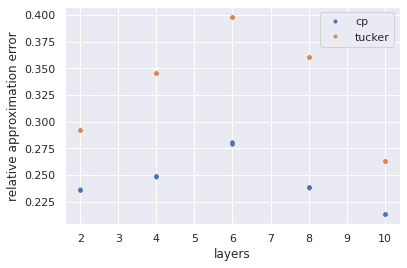

In [36]:
df_layers_idx = df_layers.set_index('layers', inplace=False)
grouped_df_layers = df_layers_idx.groupby('factorization')
ax = grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

In [37]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

# ax = grouped_df_layers['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

In [38]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

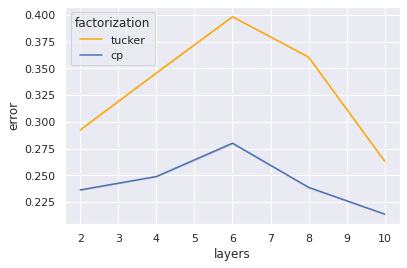

In [39]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
ax = sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             )

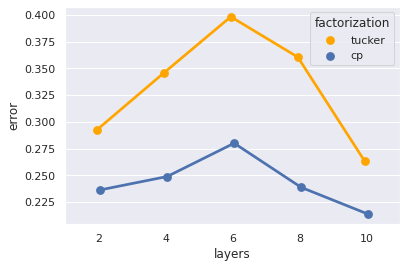

In [40]:
ax = sns.pointplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True
             )

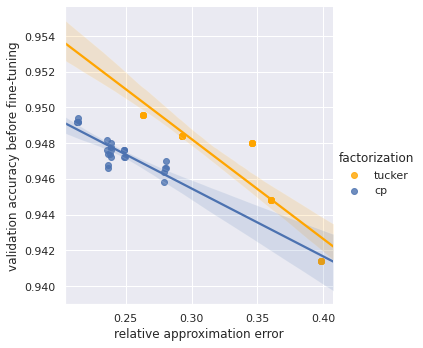

In [41]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

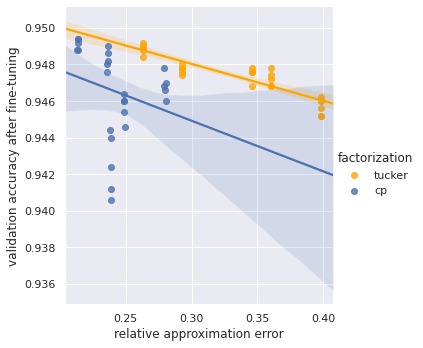

In [42]:
g = sns.lmplot(x="error", y="valid_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

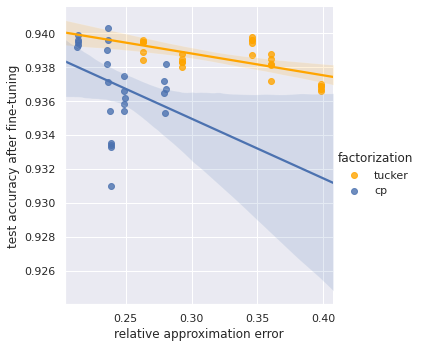

In [43]:
g = sns.lmplot(x="error", y="test_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

[Text(0.5, 0, 'layer number'),
 Text(0, 0.5, 'validation accuracy before fine-tuning')]

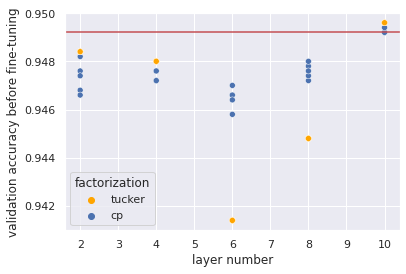

In [44]:
ax = sns.scatterplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    # dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
# ax.set(ylim=(0.908, 0.9220))

[Text(0.5, 0, 'layer number'),
 Text(0, 0.5, 'validation accuracy before fine-tuning')]

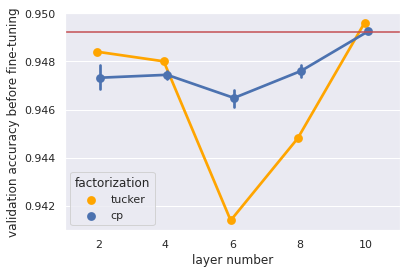

In [45]:
ax = sns.pointplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
# ax.set(ylim=(0.908, 0.9220))

[Text(0.5, 0, 'layer number'),
 Text(0, 0.5, 'validation accuracy after fine-tuning')]

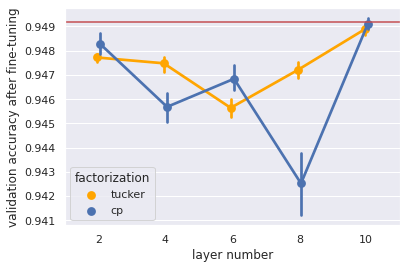

In [46]:
ax = sns.pointplot(x="layers", y="valid_acc",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy after fine-tuning')
# ax.set(ylim=(0.908, 0.9220))


[Text(0.5, 0, 'layer number'), Text(0, 0.5, 'test accuracy after fine-tuning')]

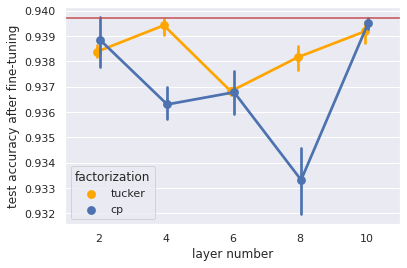

In [47]:
ax = sns.pointplot(x="layers", y="test_acc",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='layer number', ylabel='test accuracy after fine-tuning')

In [48]:
df.factorization.isna()

0      False
1      False
2      False
3      False
4      False
       ...  
245    False
246    False
247    False
248    False
249    False
Name: factorization, Length: 250, dtype: bool

In [49]:
df[df.error.isnull()]

Empty DataFrame
Columns: [name, nr, error, layers, factorization, rank, valid_acc, valid_acc_before_ft, n_param_fact, test_acc, lr, optimizer, norm_diff, norm_b, n_b, relative_norm, scaled_norm, fact_rank, fact_layers, layers_fact]
Index: []

In [50]:
df_layer_rank = df.groupby(['factorization','layers','rank'])
df_std = df_layer_rank[['valid_acc','test_acc']].std()

print(df_std.to_latex())

# df.to_json("/home/jetzeschuurman/gitProjects/phd/tddl/artifacts/f_mnist/std_adam.json")

\begin{tabular}{lllrr}
\toprule
       &    &      &  valid\_acc &  test\_acc \\
factorization & layers & rank &            &           \\
\midrule
cp & 2 & 0.10 &   0.000932 &  0.002214 \\
       &    & 0.25 &   0.000518 &  0.000709 \\
       &    & 0.50 &   0.000540 &  0.001242 \\
       &    & 0.75 &   0.000316 &  0.000647 \\
       &    & 0.90 &   0.000346 &  0.000698 \\
       & 4 & 0.10 &   0.001244 &  0.001563 \\
       &    & 0.25 &   0.002233 &  0.000814 \\
       &    & 0.50 &   0.000701 &  0.000806 \\
       &    & 0.75 &   0.000374 &  0.001229 \\
       &    & 0.90 &   0.001445 &  0.001304 \\
       & 6 & 0.10 &   0.000879 &  0.001731 \\
       &    & 0.25 &   0.000984 &  0.001585 \\
       &    & 0.50 &   0.000654 &  0.001057 \\
       &    & 0.75 &   0.000684 &  0.001270 \\
       &    & 0.90 &   0.000607 &  0.000675 \\
       & 8 & 0.10 &   0.002958 &  0.002887 \\
       &    & 0.25 &   0.002205 &  0.003171 \\
       &    & 0.50 &   0.001671 &  0.001561 \\
       &    & 

## Analysis on the features space

### Relative Norm

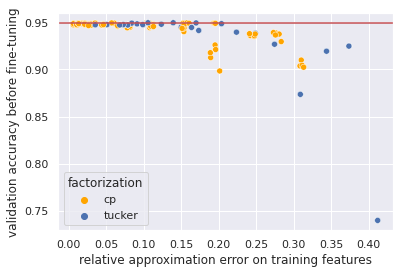

In [51]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
     hue="factorization", 
    # style="factorization",
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

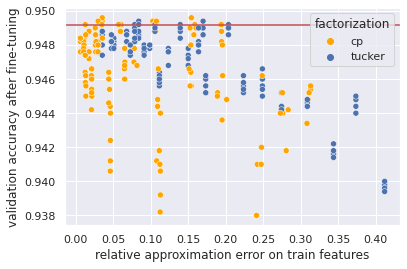

In [52]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
     hue="factorization", 
    # style="factorization",
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

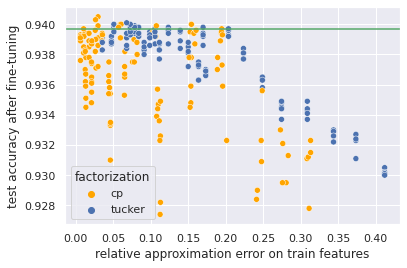

In [53]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))

### Scaled Norm

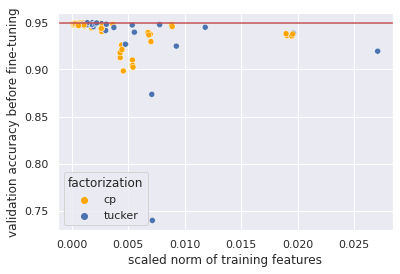

In [54]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

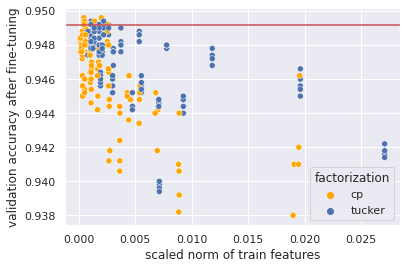

In [55]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

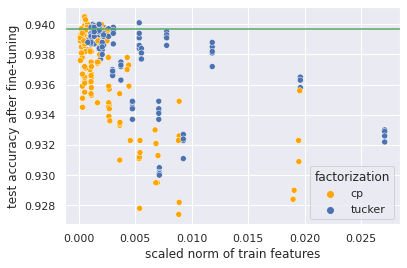

In [56]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))

### Norm of Difference

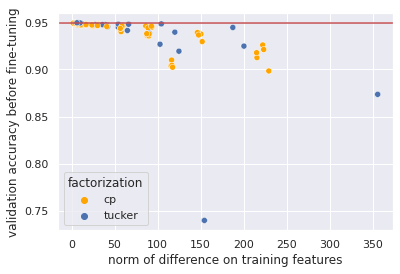

In [57]:
ax = sns.scatterplot(
    x="norm_diff", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='norm of difference on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

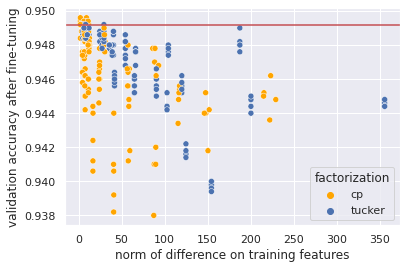

In [58]:
ax = sns.scatterplot(x="norm_diff", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='norm of difference on training features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

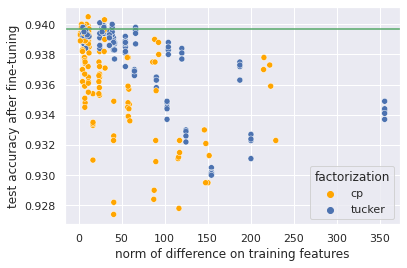

In [59]:
ax = sns.scatterplot(x="norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))

In [60]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

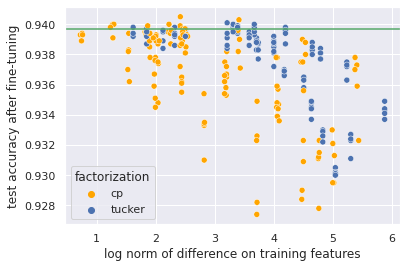

In [61]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='log norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))

In [62]:
df['log_test_acc'] = np.log(df.test_acc)

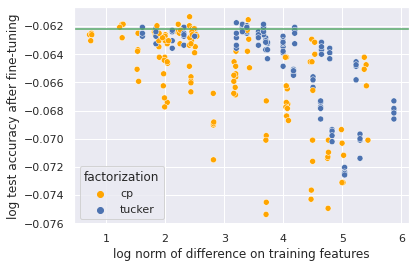

In [63]:
ax = sns.scatterplot(x="log_norm_diff", y="log_test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='log norm of difference on training features', ylabel='log test accuracy after fine-tuning')
ax.axhline(np.log(baseline_result['test_acc']), color='g')
# ax.set(ylim=(0.865, 0.925))

# Per Layer

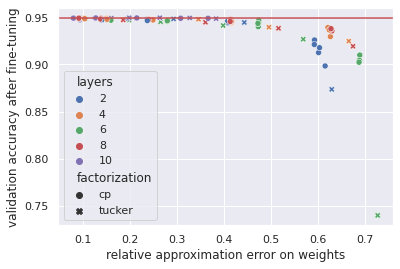

In [64]:
ax = sns.scatterplot(x="error", y="valid_acc_before_ft",
    hue="layers",
    style="factorization",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

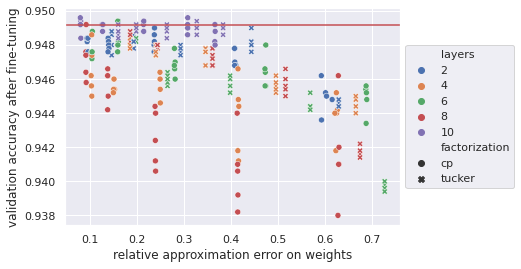

In [65]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
    
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

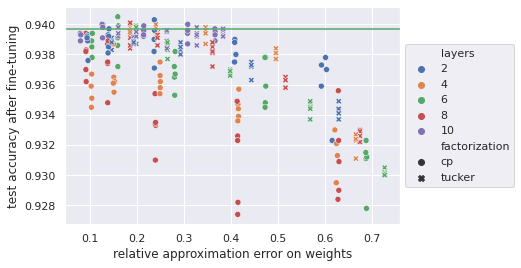

In [66]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="layers",
    style="factorization", 
    data=df,
    # palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Feature Space

### Relative Norm

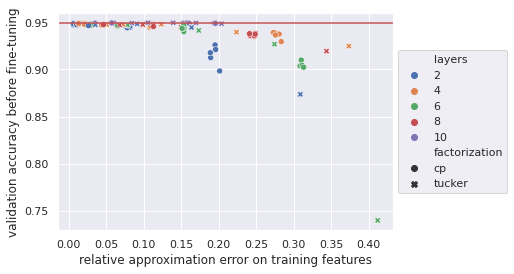

In [67]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

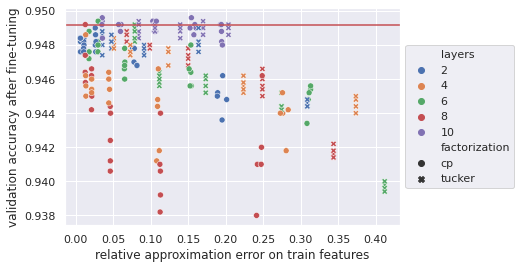

In [68]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

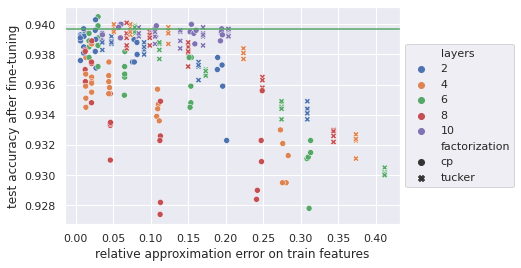

In [69]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Scaled Norm

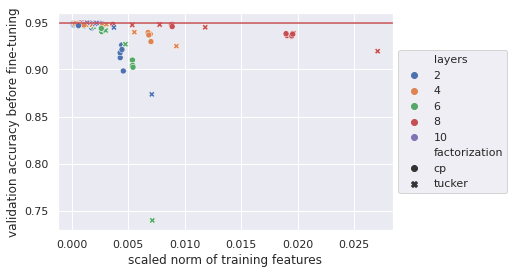

In [70]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

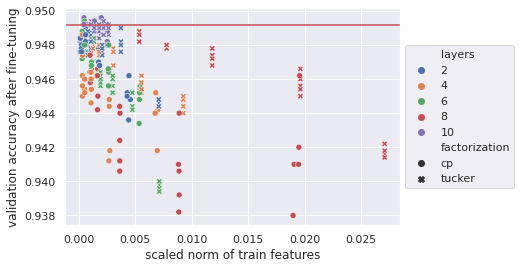

In [71]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

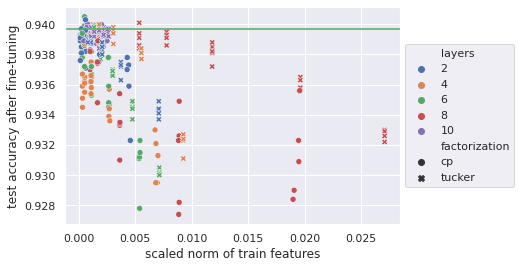

In [72]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Norm of Difference

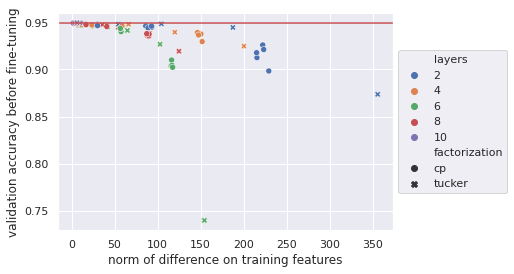

In [73]:
ax = sns.scatterplot(
    x="norm_diff", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='norm of difference on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

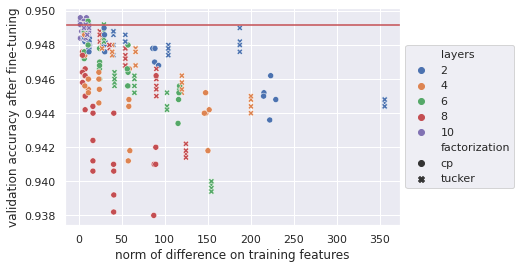

In [74]:
ax = sns.scatterplot(x="norm_diff", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='norm of difference on training features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

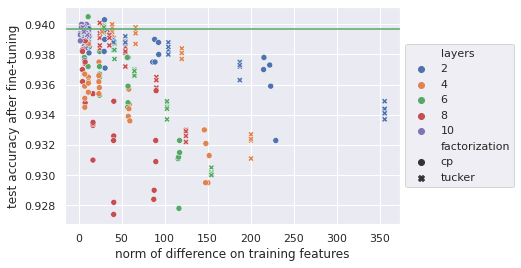

In [75]:
ax = sns.scatterplot(x="norm_diff", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [76]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

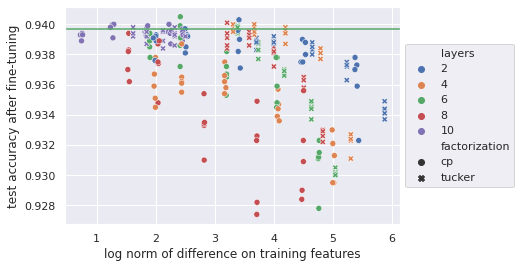

In [77]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='log norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [78]:
df['log_test_acc'] = np.log(df.test_acc)

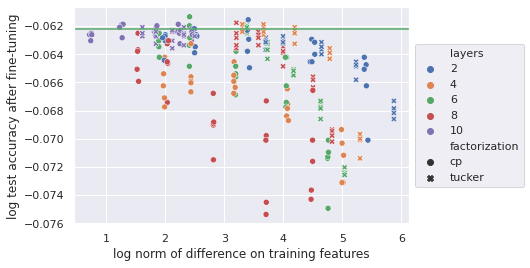

In [79]:
ax = sns.scatterplot(x="log_norm_diff", y="log_test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='log norm of difference on training features', ylabel='log test accuracy after fine-tuning')
ax.axhline(np.log(baseline_result['test_acc']), color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

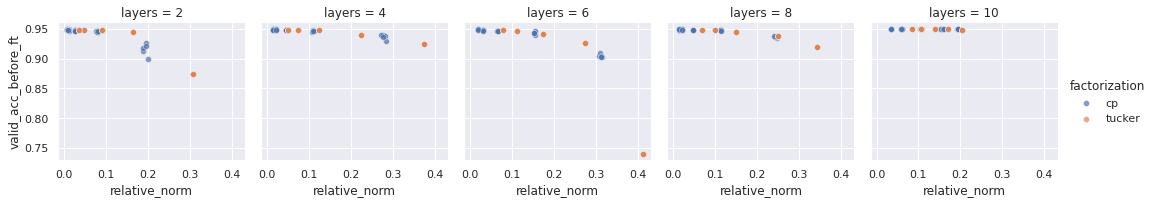

In [80]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "valid_acc_before_ft", alpha=.7)
g.add_legend()

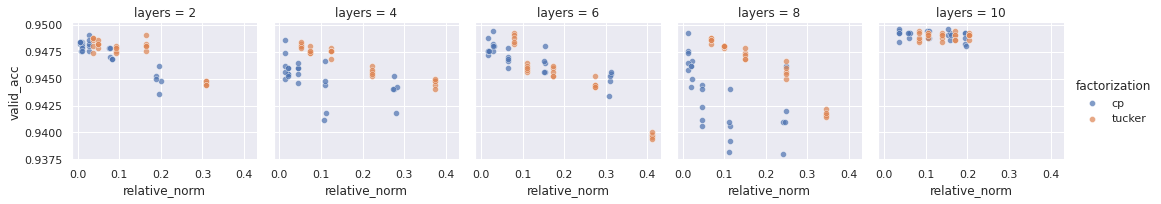

In [81]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "valid_acc", alpha=.7)
g.add_legend()

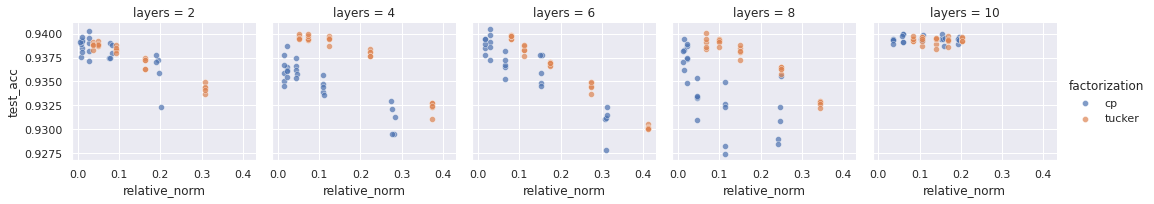

In [82]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "test_acc", alpha=.7)
g.add_legend()
# g.axhline(np.log(baseline_result['test_acc']), color='g')

In [83]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'error': 'Relative norm on weights',
    'relative_norm': 'Relative norm on training features',
    'scaled_norm': 'Scaled norm on training features',
    'norm_diff': 'Norm of the difference between training features',
    'log_norm_diff': 'Log norm of the difference between training features',
}

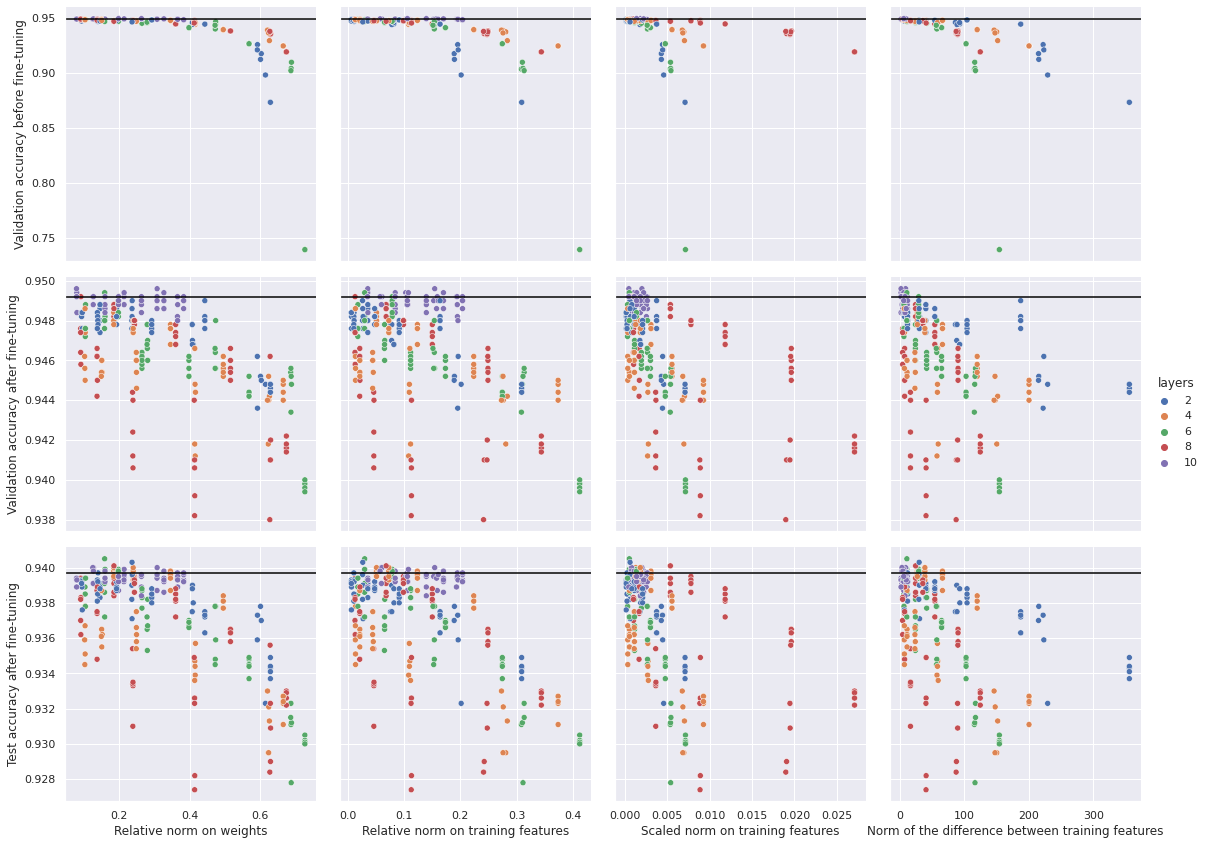

In [84]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
# g.set(ylim=ylim)
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])



/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x7fd1cfa902e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


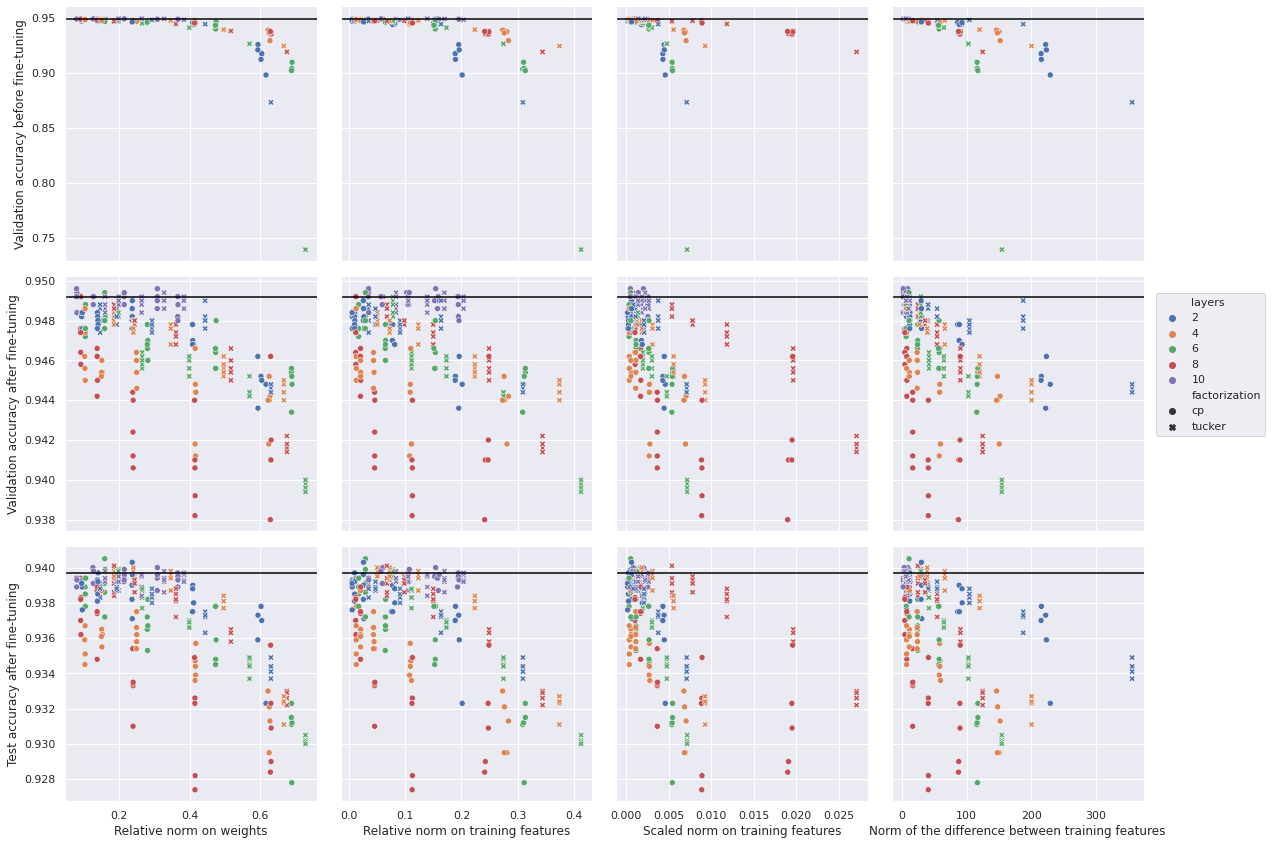

In [85]:
from matplotlib import pyplot as plt 

g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
# g.set(ylim=ylim)
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x7fd1cf385280> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


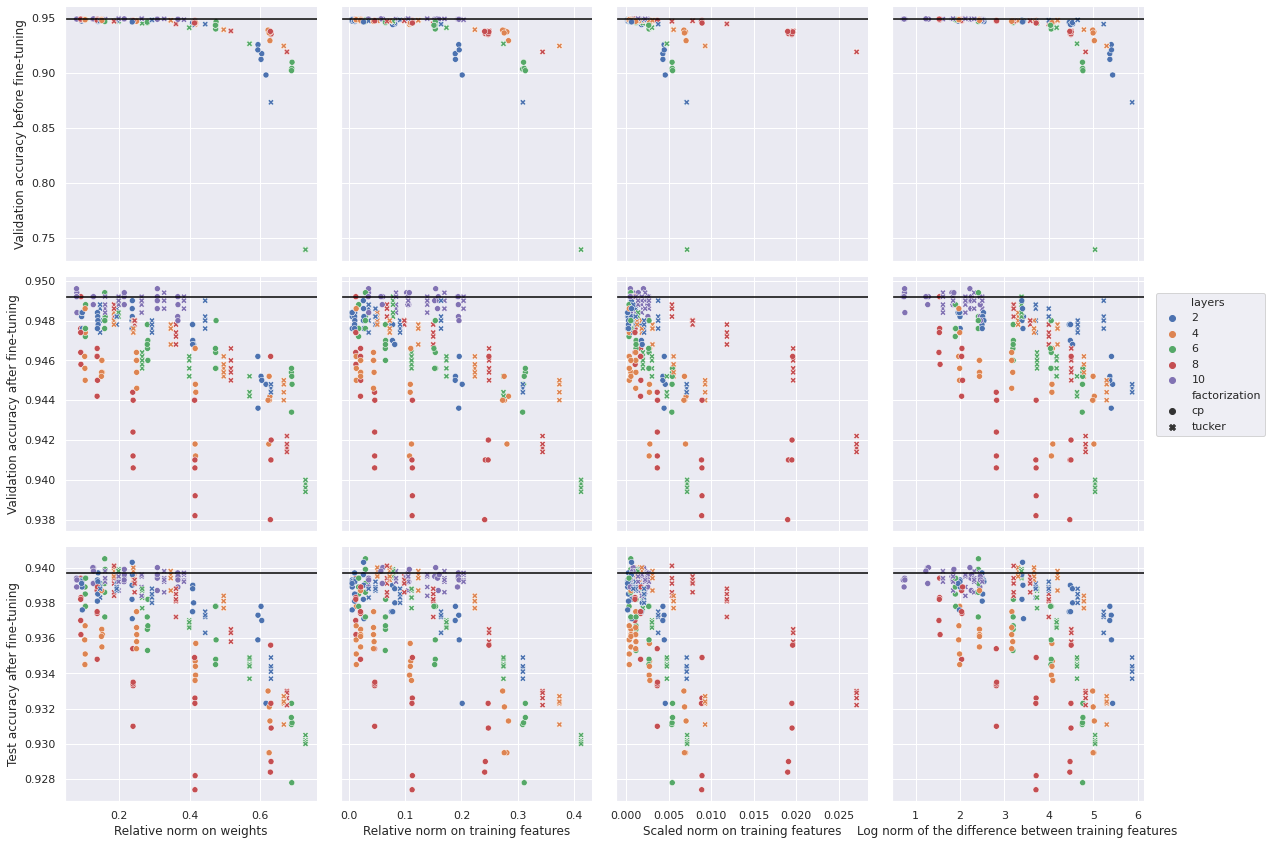

In [86]:
from matplotlib import pyplot as plt 

g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"log_norm_diff"],
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
# g.set(ylim=ylim)
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

g.savefig("../../plots/fmnist/gar/gar_fm_scatter_errors_performances_layers_factorizations")

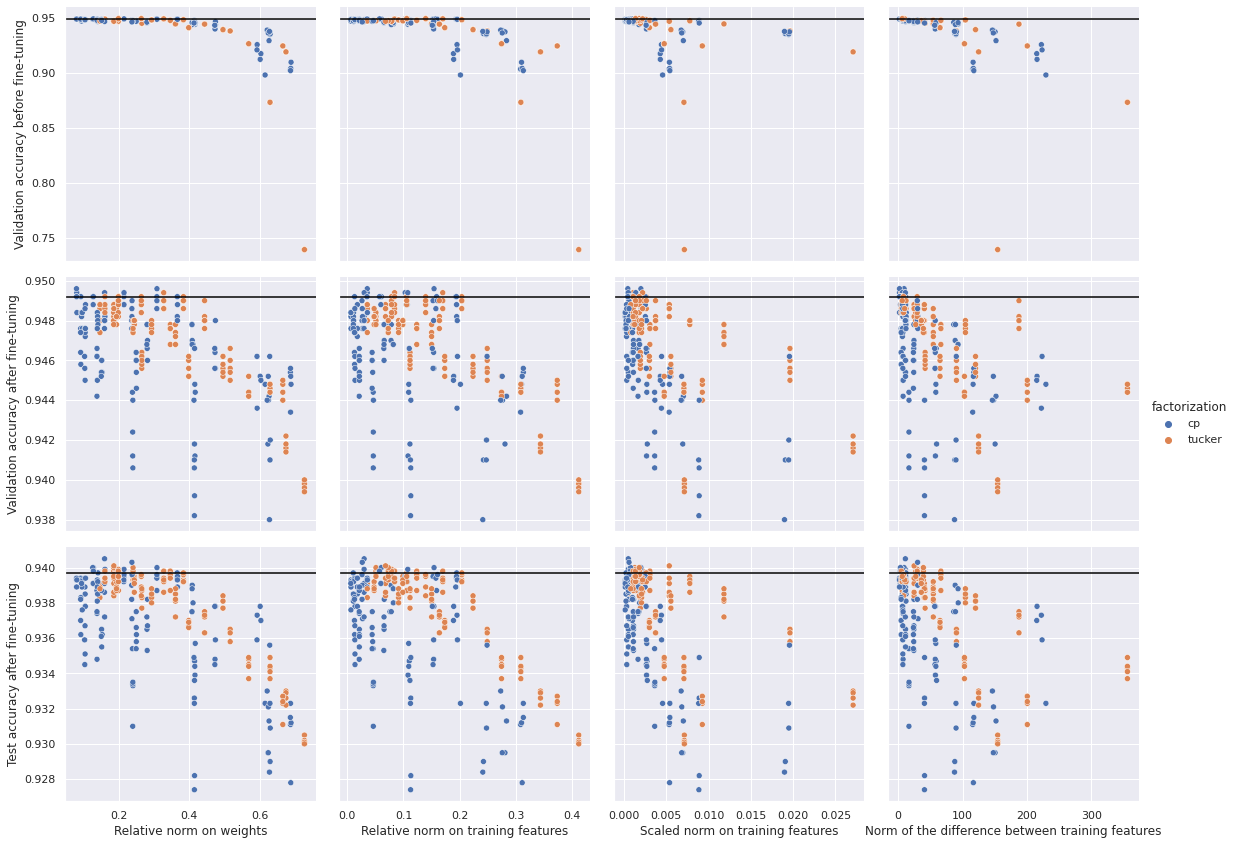

In [87]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="factorization",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
# g.set(ylim=ylim)
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

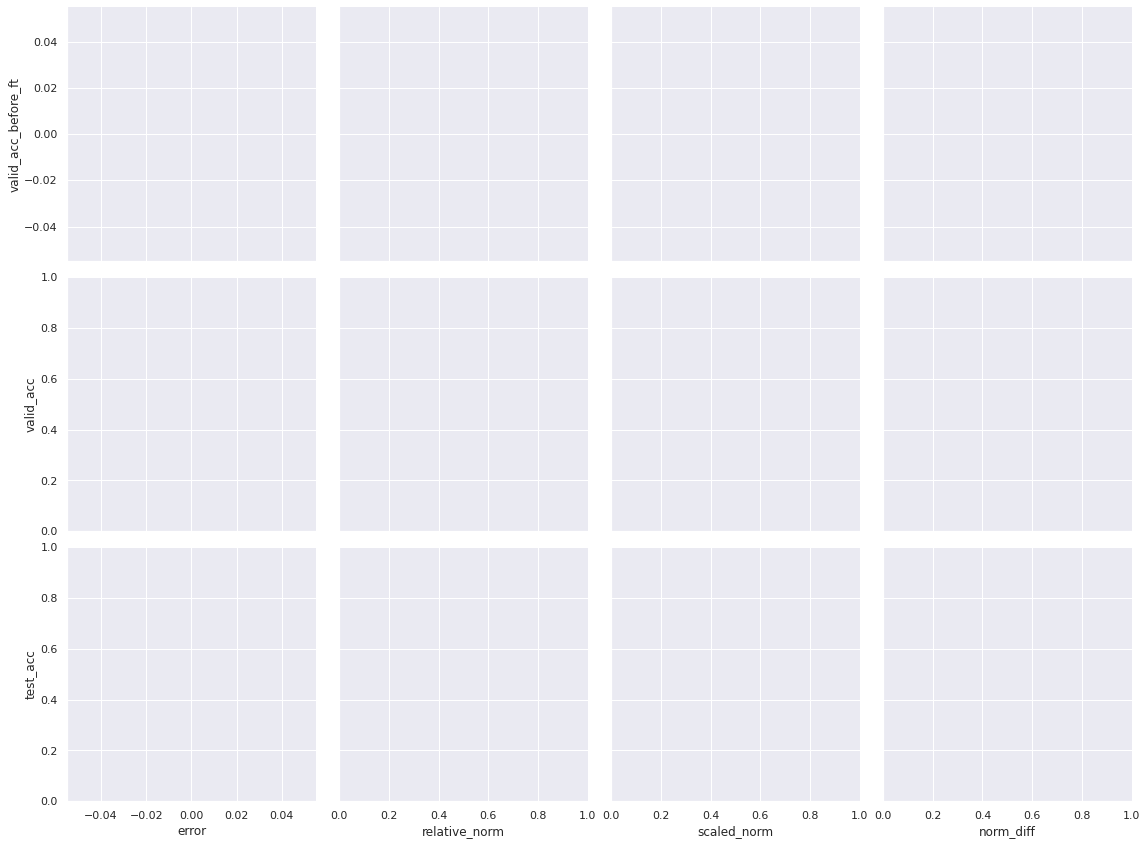

In [90]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="fact_layers",
    height=4,
    hue_order=[
        'cp-15','tucker-15','cp-19','tucker-19','cp-28','tucker-28','cp-38','tucker-38',
        'cp-41','tucker-41','cp-44','tucker-44','cp-60','tucker-60','cp-63','tucker-63',
    ]
    # palette=['b','orange']
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=ylim)
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

In [91]:
df

name  nr     error layers factorization  rank  valid_acc  \
0    conv5   8  0.137097      8            cp  0.75     0.9466   
1    conv6  10  0.126594     10            cp  0.75     0.9492   
2    conv2   2  0.292474      2        tucker  0.50     0.9478   
3    conv4   6  0.159686      6            cp  0.75     0.9482   
4    conv2   2  0.615756      2            cp  0.10     0.9448   
..     ...  ..       ...    ...           ...   ...        ...   
245  conv2   2  0.629797      2        tucker  0.10     0.9444   
246  conv2   2  0.236472      2            cp  0.50     0.9486   
247  conv2   2  0.443419      2        tucker  0.25     0.9480   
248  conv4   6  0.472469      6            cp  0.25     0.9466   
249  conv5   8  0.413202      8            cp  0.25     0.9440   

     valid_acc_before_ft  n_param_fact  test_acc  ...   norm_diff  \
0                 0.9478        520020    0.9374  ...    7.716044   
1                 0.9492        520020    0.9391  ...    3.574205   
2                 0.9484        538325    0.9383  ...  104.404582   
3                 0.9474        520020    0.9399  ...   11.156350   
4                 0.8984        523406    0.9323  ...  229.319759   
..                   ...           ...       ...  ...         ...   
245               0.8736        523200    0.9341  ...  355.858847   
246               0.9466        538256    0.9403  ...   30.193903   
247               0.9446        529056    0.9373  ...  187.511633   
248               0.9436        446117    0.9378  ...   56.668492   
249               0.9456        446117    0.9349  ...   41.007774   

          norm_b      n_b  relative_norm  scaled_norm    fact_rank  \
0     363.930520   4608.0       0.021301     0.001674      cp-0.75   
1      60.104838   4608.0       0.059740     0.000776      cp-0.75   
2    1146.403785  50176.0       0.091298     0.002081   tucker-0.5   
3     375.486152  21632.0       0.029868     0.000516      cp-0.75   
4    1146.403785  50176.0       0.201407     0.004570       cp-0.1   
..           ...      ...            ...          ...          ...   
245  1146.403785  50176.0       0.308971     0.007092   tucker-0.1   
246  1146.403785  50176.0       0.026562     0.000602       cp-0.5   
247  1146.403785  50176.0       0.163900     0.003737  tucker-0.25   
248   375.486152  21632.0       0.151310     0.002620      cp-0.25   
249   363.930520   4608.0       0.113119     0.008899      cp-0.25   

     fact_layers layers_fact log_norm_diff log_test_acc  
0           cp-8        8-cp      2.043302    -0.064645  
1          cp-10       10-cp      1.273743    -0.062833  
2       tucker-2    2-tucker      4.648274    -0.063686  
3           cp-6        6-cp      2.412009    -0.061982  
4           cp-2        2-cp      5.435117    -0.070101  
..           ...         ...           ...          ...  
245     tucker-2    2-tucker      5.874534    -0.068172  
246         cp-2        2-cp      3.407640    -0.061556  
247     tucker-2    2-tucker      5.233841    -0.064752  
248         cp-6        6-cp      4.037218    -0.064219  
249         cp-8        8-cp      3.713762    -0.067316  

[250 rows x 22 columns]

# Kendals tau

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

In [13]:
def p_to_asterisks(p):
    """
    Estimates are significantly different from zero at 1\% significance level, 
    unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), 
    or not significantly different from zero (***).
    """
    if p < 0.01:
        asterisk = ""
    elif p < 0.05:
        asterisk = "*"
    elif p < 0.1:
        asterisk = "**"
    else:
        asterisk = "***"
    return asterisk

In [14]:
# from scipy.stats import kendalltau
from tddl.post_processing.kendalls_tau import kendalltau_a

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

# TODO: make multilevel columns 
# https://stackoverflow.com/questions/21443963/pandas-multilevel-column-names

metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff','layers']
# errors = ['relative_norm_weight','scaled_norm_weight','diff_norm_weight', 'relative_norm','scaled_norm','norm_diff','layers']
# metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_kt = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        corr, p = kendalltau_a(df[error], df[metric])
        df_kt[error][metric] = "{:.2f}{}".format(corr,p_to_asterisks(p))

In [15]:
df_kt

relative_norm_weight relative_norm  \
log_valid_error_before_ft                 0.57          0.43   
log_valid_error                           0.40          0.25   
log_test_error                            0.41          0.28   

                          scaled_norm_weight scaled_norm diff_norm_weight  \
log_valid_error_before_ft               0.59        0.45             0.65   
log_valid_error                         0.43        0.36             0.50   
log_test_error                          0.39        0.34             0.46   

                          norm_diff layers  
log_valid_error_before_ft      0.68  -0.27  
log_valid_error                0.46  -0.17  
log_test_error                 0.40  -0.14

In [16]:
# df_kt.to_pickle("./tables/kt_gar_fm_classification_error.zip")

In [17]:
neat_table_indices = {
    'valid_acc_before_ft': "Val. before f.t.",
    'valid_acc': "Val. after f.t.",
    'test_acc': "Test after f.t.",
}
neat_table_columns = {
    'error': "Relative-weights",
    'relative_norm': "Relative-features",
    'scaled_norm': "Scaled-features",
    'norm_diff': "Difference-features"}
df_kt.rename(index=neat_table_indices,columns=neat_table_columns, inplace=True)
df_kt

relative_norm_weight Relative-features  \
log_valid_error_before_ft                 0.57              0.43   
log_valid_error                           0.40              0.25   
log_test_error                            0.41              0.28   

                          scaled_norm_weight Scaled-features diff_norm_weight  \
log_valid_error_before_ft               0.59            0.45             0.65   
log_valid_error                         0.43            0.36             0.50   
log_test_error                          0.39            0.34             0.46   

                          Difference-features layers  
log_valid_error_before_ft                0.68  -0.27  
log_valid_error                          0.46  -0.17  
log_test_error                           0.40  -0.14

In [18]:
print(df_kt.to_latex(
    float_format="{:0.2f}".format, 
    position='htbp', 
    caption="Kendall's tau from GaripovNet on Fashion-MNIST for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.",
    label='kt_gar_fm_errors_performances',
))

\begin{table}[htbp]
\centering
\caption{Kendall's tau from GaripovNet on Fashion-MNIST for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.}
\label{kt_gar_fm_errors_performances}
\begin{tabular}{llllllll}
\toprule
{} & relative\_norm\_weight & Relative-features & scaled\_norm\_weight & Scaled-features & diff\_norm\_weight & Difference-features & layers \\
\midrule
log\_valid\_error\_before\_ft &                 0.57 &              0.43 &               0.59 &            0.45 &             0.65 &                0.68 &  -0.27 \\
log\_valid\_error           &                 0.40 &              0.25 &               0.43 &           

In [19]:
df.layers.astype(str).unique()

array(['8', '10', '2', '6', '4'], dtype=object)

In [20]:
errors_metrics = []

for error in errors:
    for metric in metrics:
        errors_metrics.append(f'{error}-{metric}')

layers = ['2','4','6','8','10']

df_kt_layers = pd.DataFrame(
    index=errors_metrics,
    columns=layers,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = kendalltau(df_layer[error], df_layer[metric])
            df_kt_layers[str(layer)][f'{error}-{metric}'] = "{:.2f}{}".format(corr,p_to_asterisks(p))
    

NameError: name 'kendalltau' is not defined

In [21]:
neat_table_indices_layers = {
    'error-valid_acc_before_ft': "Val. before f.t.-weight",
    'error-valid_acc': "Val. after f.t.-weight",
    'error-test_acc': "Test after f.t.-weight",

    'relative_norm-valid_acc_before_ft': "Val. before f.t.-rel. feat.",
    'relative_norm-valid_acc': "Val. after f.t.-rel. feat.",
    'relative_norm-test_acc': "Test after f.t.-rel. feat.",

    'scaled_norm-valid_acc_before_ft': "Val. before f.t.-sc. feat",
    'scaled_norm-valid_acc': "Val. after f.t.-sc. feat",
    'scaled_norm-test_acc': "Test after f.t.-sc. feat",

    'norm_diff-valid_acc_before_ft': "Val. before f.t.-diff. feat",
    'norm_diff-valid_acc': "Val. after f.t.-diff. feat",
    'norm_diff-test_acc': "Test after f.t.-diff. feat",
}

df_kt_layers.rename(index=neat_table_indices_layers, inplace=True)
df_kt_layers

2    4    6    8   10
relative_norm_weight-log_valid_error_before_ft  NaN  NaN  NaN  NaN  NaN
relative_norm_weight-log_valid_error            NaN  NaN  NaN  NaN  NaN
relative_norm_weight-log_test_error             NaN  NaN  NaN  NaN  NaN
relative_norm-log_valid_error_before_ft         NaN  NaN  NaN  NaN  NaN
relative_norm-log_valid_error                   NaN  NaN  NaN  NaN  NaN
relative_norm-log_test_error                    NaN  NaN  NaN  NaN  NaN
scaled_norm_weight-log_valid_error_before_ft    NaN  NaN  NaN  NaN  NaN
scaled_norm_weight-log_valid_error              NaN  NaN  NaN  NaN  NaN
scaled_norm_weight-log_test_error               NaN  NaN  NaN  NaN  NaN
scaled_norm-log_valid_error_before_ft           NaN  NaN  NaN  NaN  NaN
scaled_norm-log_valid_error                     NaN  NaN  NaN  NaN  NaN
scaled_norm-log_test_error                      NaN  NaN  NaN  NaN  NaN
diff_norm_weight-log_valid_error_before_ft      NaN  NaN  NaN  NaN  NaN
diff_norm_weight-log_valid_error                NaN  NaN  NaN  NaN  NaN
diff_norm_weight-log_test_error                 NaN  NaN  NaN  NaN  NaN
norm_diff-log_valid_error_before_ft             NaN  NaN  NaN  NaN  NaN
norm_diff-log_valid_error                       NaN  NaN  NaN  NaN  NaN
norm_diff-log_test_error                        NaN  NaN  NaN  NaN  NaN
layers-log_valid_error_before_ft                NaN  NaN  NaN  NaN  NaN
layers-log_valid_error                          NaN  NaN  NaN  NaN  NaN
layers-log_test_error                           NaN  NaN  NaN  NaN  NaN

In [22]:
print(df_kt_layers.to_latex(
    position='htbp', 
    caption="Kendall's tau from GaripovNet on Fashion-MNIST conditioned on the layer for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
    label='tab:kt_gar_fm_errors_performances_layers',
))

\begin{table}[htbp]
\centering
\caption{Kendall's tau from GaripovNet on Fashion-MNIST conditioned on the layer for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).}
\label{tab:kt_gar_fm_errors_performances_layers}
\begin{tabular}{llllll}
\toprule
{} &    2 &    4 &    6 &    8 &   10 \\
\midrule
relative\_norm\_weight-log\_valid\_error\_before\_ft &  NaN &  NaN &  NaN &  NaN &  NaN \\
relative\_norm\_weight-log\_valid\_error           &  NaN &  NaN &  NaN &  NaN &  NaN 

In [23]:
df.factorization.unique()

array(['cp', 'tucker'], dtype=object)

In [25]:
factorizations = ['cp', 'tucker']

df_kt_factorizations = pd.DataFrame(
    index=errors_metrics,
    columns=factorizations,
)

for fact in df.factorization.unique():
    df_ = df[df.factorization==fact]
    for error in errors:
        for metric in metrics:
            corr, p = kendalltau_a(df_[error], df_[metric])
            df_kt_factorizations[str(fact)][f'{error}-{metric}'] = "{:.2f}{}".format(corr,p_to_asterisks(p))

df_kt_factorizations.rename(index=neat_table_indices_layers, inplace=True)

print(df_kt_factorizations.to_latex(
    position='htbp', 
    caption="Kendall's tau from GaripovNet on Fashion-MNIST conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
    label='tab:kt_gar_fm_errors_performances_factorization',
))
    

\begin{table}[htbp]
\centering
\caption{Kendall's tau from GaripovNet on Fashion-MNIST conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).}
\label{tab:kt_gar_fm_errors_performances_factorization}
\begin{tabular}{lll}
\toprule
{} &       cp &  tucker \\
\midrule
relative\_norm\_weight-log\_valid\_error\_before\_ft &     0.58 &    0.54 \\
relative\_norm\_weight-log\_valid\_error           &     0.35 &    0.56 \\
relative\_norm\_weight-log\

## Mean and std

In [26]:
metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

In [27]:
from tddl.post_processing.kendalls_tau import split_into_run, calculate_kendalls_tau_per_run, mean_std_over_runs

dfs = split_into_run(df, 5)
df_kts = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
df_kt_mean_std = mean_std_over_runs(df_kts, errors=errors, metrics=metrics)
df_kt_mean_std

relative_norm_weight relative_norm  \
log_valid_error_before_ft            0.57±0.01     0.44±0.02   
log_valid_error                      0.40±0.03     0.25±0.03   
log_test_error                       0.42±0.02     0.29±0.02   

                          scaled_norm_weight scaled_norm diff_norm_weight  \
log_valid_error_before_ft          0.59±0.01   0.46±0.02        0.66±0.01   
log_valid_error                    0.43±0.03   0.37±0.02        0.51±0.02   
log_test_error                     0.39±0.02   0.35±0.01        0.47±0.03   

                           norm_diff  
log_valid_error_before_ft  0.69±0.01  
log_valid_error            0.46±0.03  
log_test_error             0.40±0.02

In [28]:
# df_kt_mean_std.to_pickle("./tables/kt_gar_fm_mean_std.zip")

In [29]:
from tddl.post_processing.kendalls_tau import dfs_for_bar

df_bar = dfs_for_bar(df_kts, dataset='F-MNIST', model='GaripovNet',
    errors=errors, 
    metrics=metrics,
)
df_bar.to_pickle("./tables/kta_gar_fm_bar_log_error.zip")

## per Layer

In [31]:
# from scipy.stats import kendalltau
from tddl.post_processing.kendalls_tau import kendalltau_a

dfs = split_into_run(df, 5)
# n = 0
# layer = 63
model = 'GaripovNet'
dataset = 'F-MNIST'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error']
approxs = ['relative_norm_weight','relative_norm'] # ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
layers = [2,4,6,8,10]
N = 5

df_layers_ = pd.DataFrame(columns=['kt','layer', 'run', 'performance_metric', 'approximation_error'])
df_means = pd.DataFrame(columns=approxs, index=performs)

array = np.zeros((len(performs),len(approxs),len(layers),N))

for p, perform in enumerate(performs):
    print(perform)
    for a, approx in enumerate(approxs):
        print(approx)
        arr = np.zeros((len(layers),N))
        for l, layer in enumerate(layers):
            for n in range(N):
                df_n = dfs[n]
                df_n_l = df_n.loc[df_n.layers == layer]
                # print(df_n_l)
                c, _ = kendalltau_a(df_n_l[perform],df_n_l[approx])
                print(f"Layer: {layer}, run: {n}, Kendall's tau {c}")
                df_layers_ = df_layers_.append({
                    'layer':layer,
                    'run':n,
                    'performance_metric':perform,
                    'approximation_error':approx,
                    'kt': c,
                    'model': model,
                    'dataset': dataset,
                }, ignore_index=True)
                array[p, a, l, n] = c
                arr[l,n] = c 
        df_means[approx][perform] = arr.mean()

df_layers_.to_pickle("./tables/kta_gar_fm_bar_log_error_layers.zip")

log_valid_error_before_ft
relative_norm_weight
Layer: 2, run: 0, Kendall's tau 0.7555555555555555
Layer: 2, run: 1, Kendall's tau 0.4
Layer: 2, run: 2, Kendall's tau 0.7777777777777778
Layer: 2, run: 3, Kendall's tau 0.8222222222222222
Layer: 2, run: 4, Kendall's tau 0.6222222222222222
Layer: 4, run: 0, Kendall's tau 0.7777777777777778
Layer: 4, run: 1, Kendall's tau 0.8
Layer: 4, run: 2, Kendall's tau 0.8444444444444444
Layer: 4, run: 3, Kendall's tau 0.6222222222222222
Layer: 4, run: 4, Kendall's tau 0.7555555555555555
Layer: 6, run: 0, Kendall's tau 0.9111111111111111
Layer: 6, run: 1, Kendall's tau 0.8
Layer: 6, run: 2, Kendall's tau 0.9111111111111111
Layer: 6, run: 3, Kendall's tau 0.9555555555555556
Layer: 6, run: 4, Kendall's tau 0.8666666666666667
Layer: 8, run: 0, Kendall's tau 0.8
Layer: 8, run: 1, Kendall's tau 0.8222222222222222
Layer: 8, run: 2, Kendall's tau 0.8
Layer: 8, run: 3, Kendall's tau 0.6666666666666666
Layer: 8, run: 4, Kendall's tau 0.7777777777777778
Layer: 1

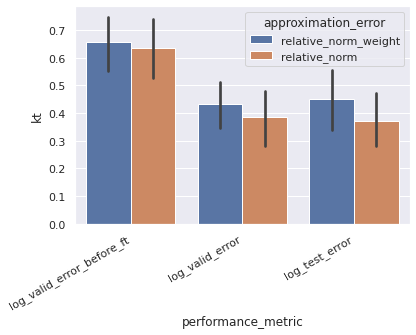

In [32]:
ax = sns.barplot(
    x='performance_metric',
    y='kt',
    hue='approximation_error',
    data=df_layers_,
    # ci="sd", palette="dark", alpha=.6, height=6,
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, fontdict={'horizontalalignment':'right'})# 'center', 'left', 'right')
fig = ax.get_figure()

# Pearson Correlation

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [112]:
from scipy.stats import pearsonr

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

errors = ['error', 'relative_norm','scaled_norm','norm_diff']
metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_pr = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        corr, p = pearsonr(df[error], df[metric])
        df_pr[error][metric] = corr

In [114]:
df_pr.rename(index=neat_table_indices,columns=neat_table_columns, inplace=True)

print(df_kt.to_latex(
    float_format="{:0.2f}".format, 
    position='htbp', 
    caption="Pearson's rho from GaripovNet on Fashion-MNIST for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.",
    label='pr_gar_fm_errors_performances',
))

\begin{table}[htbp]
\centering
\caption{Pearson's rho from GaripovNet on Fashion-MNIST for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.}
\label{pr_gar_fm_errors_performances}
\begin{tabular}{lllll}
\toprule
{} & Relative-weights & Relative-features & Scaled-features & Difference-features \\
\midrule
Val. before f.t. &            -0.58 &             -0.44 &           -0.46 &               -0.70 \\
Val. after f.t.  &            -0.41 &             -0.25 &           -0.37 &               -0.46 \\
Test after f.t.  &            -0.42 &             -0.28 &           -0.35 &               -0.40 \\
\bottomrule
\end{tabular}
\end{tab

In [115]:
df_pr_layers = pd.DataFrame(
    index=layers,
    columns=errors_metrics,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = pearsonr(df_layer[error], df_layer[metric])
            df_pr_layers[f'{error}-{metric}'][str(layer)] = (corr, p)

In [116]:
df_pr_layers

error-valid_acc_before_ft  \
2    (-0.7759716265148436, 3.608947060953461e-11)   
4   (-0.8665953797838822, 4.2433692663667893e-16)   
6    (-0.6841477155563489, 4.317814254691111e-08)   
8    (-0.8412210228685492, 2.052114472121337e-14)   
10   (-0.34684907168843415, 0.013598497931872774)   

                                  error-valid_acc  \
2   (-0.8190096949037743, 3.6422431353052215e-13)   
4    (-0.5592227326869632, 2.427315864798197e-05)   
6   (-0.8256505706104937, 1.6084550600272878e-13)   
8    (-0.5815945020773913, 9.449818090534413e-06)   
10    (-0.25017971673966527, 0.07972600210058092)   

                                   error-test_acc  \
2   (-0.8053778630774453, 1.7648880460376149e-12)   
4     (-0.6295386999491072, 9.70587281420414e-07)   
6    (-0.9205510749664814, 3.146243122976677e-21)   
8    (-0.6052644204318841, 3.218371158455012e-06)   
10       (-0.0487665796773162, 0.736636955225362)   

                relative_norm-valid_acc_before_ft  \
2    (-0.8877181766265114, 8.677494425731124e-18)   
4   (-0.9429862541100122, 1.4133830571022441e-24)   
6    (-0.7940233585258816, 5.994794915878356e-12)   
8   (-0.9132991153756429, 2.3555205288632397e-20)   
10   (-0.33634486154747656, 0.016931087946133468)   

                          relative_norm-valid_acc  \
2    (-0.8157504368987635, 5.374483620557579e-13)   
4    (-0.4618137557330186, 0.0007356373907255679)   
6   (-0.8922721406651198, 3.3872082596900856e-18)   
8   (-0.40316143425836964, 0.0036961607585029067)   
10    (-0.2662376018348479, 0.061642961486122756)   

                           relative_norm-test_acc  \
2    (-0.8657688911334311, 4.873747580265144e-16)   
4    (-0.5954995301745672, 5.071452479207612e-06)   
6   (-0.9056973875618551, 1.6220155032570682e-19)   
8    (-0.42226123437021446, 0.002253792922473788)   
10     (-0.05824031901829785, 0.6878706546624496)   

                  scaled_norm-valid_acc_before_ft  \
2    (-0.8892526705330502, 6.349243524767019e-18)   
4   (-0.9430000607708453, 1.4054114111706493e-24)   
6    (-0.7940688647337761, 5.966399213276616e-12)   
8    (-0.9133862650815261, 2.301653081759719e-20)   
10   (-0.33658396278239733, 0.016848145239244126)   

                            scaled_norm-valid_acc  \
2    (-0.8149364770977074, 5.915841378268879e-13)   
4   (-0.46127786931947473, 0.0007475630490768542)   
6    (-0.892251506965678, 3.4019974968238663e-18)   
8    (-0.40262547158227757, 0.003746302057875422)   
10   (-0.26628718221677583, 0.061592716585414174)   

                             scaled_norm-test_acc  \
2       (-0.865868483159553, 4.7933132031534e-16)   
4    (-0.5948714649460929, 5.219316421359007e-06)   
6    (-0.905723938163791, 1.6115845622652463e-19)   
8   (-0.42167121541355346, 0.0022894828185971213)   
10     (-0.05819889393831122, 0.6880813464297334)   

                    norm_diff-valid_acc_before_ft  \
2    (-0.8892526705330502, 6.349243524767019e-18)   
4   (-0.9430000607708453, 1.4054114111706493e-24)   
6     (-0.794068864733776, 5.966399213276676e-12)   
8   (-0.9133862650815262, 2.3016530817596474e-20)   
10   (-0.33658396278239733, 0.016848145239244126)   

                             norm_diff-valid_acc  \
2   (-0.8149364770977074, 5.915841378268879e-13)   
4   (-0.4612778693194748, 0.0007475630490768542)   
6   (-0.892251506965678, 3.4019974968238663e-18)   
8   (-0.40262547158227757, 0.003746302057875422)   
10   (-0.2662871822167759, 0.061592716585414174)   

                              norm_diff-test_acc  
2   (-0.8658684831595529, 4.793313203153483e-16)  
4   (-0.5948714649460928, 5.219316421359025e-06)  
6   (-0.905723938163791, 1.6115845622652463e-19)  
8   (-0.42167121541355357, 0.002289482818597109)  
10    (-0.05819889393831125, 0.6880813464297334)

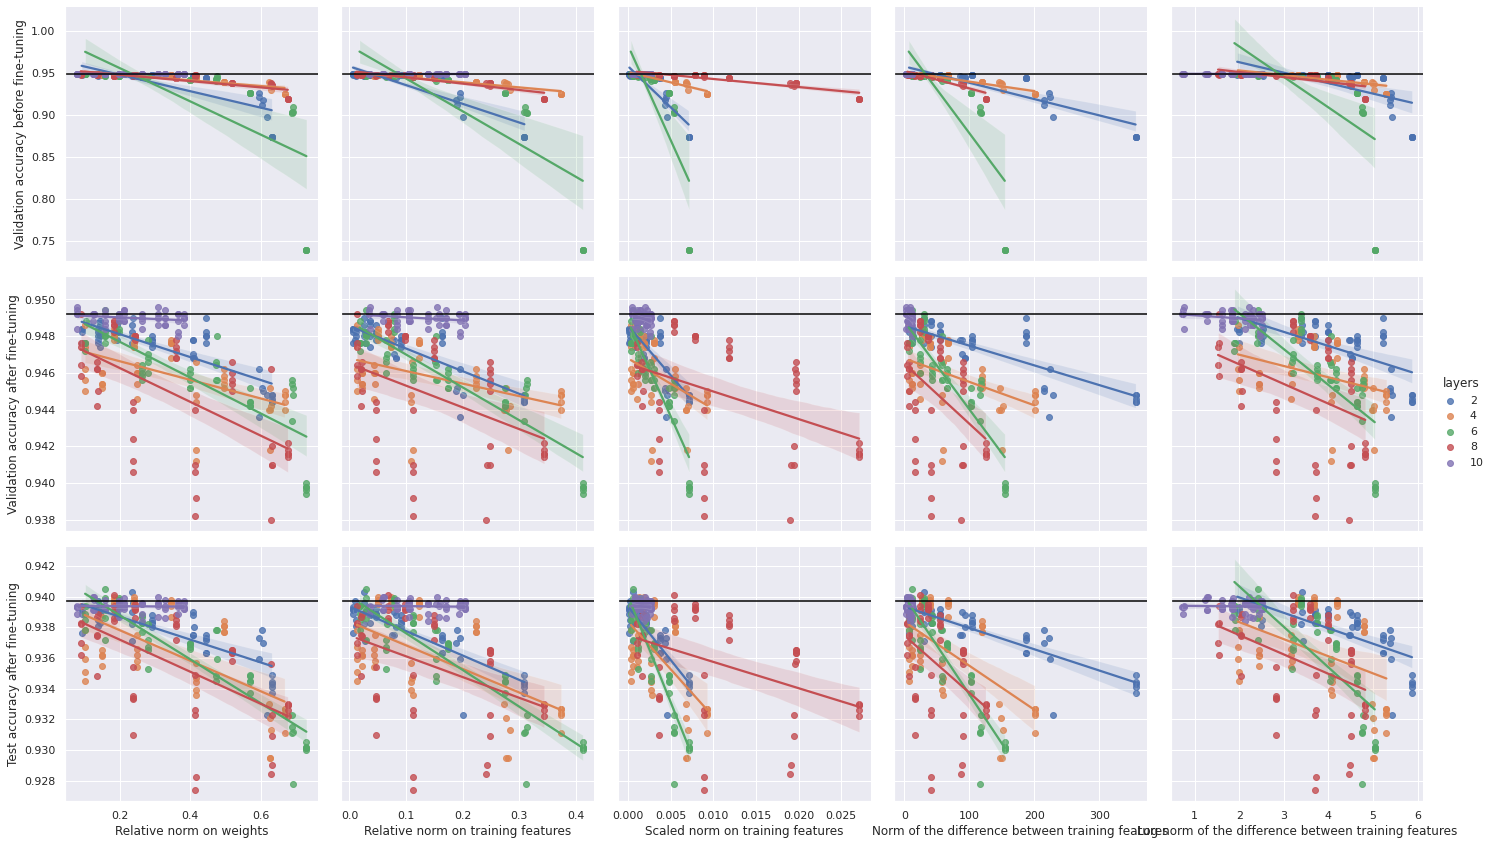

In [117]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm","norm_diff" ,"log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.regplot) # color=".3")
# g.set(ylim=ylim)
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(5):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.savefig("../../plots/fmnist/gar/gar_fm_linear_errors_performances_layers")

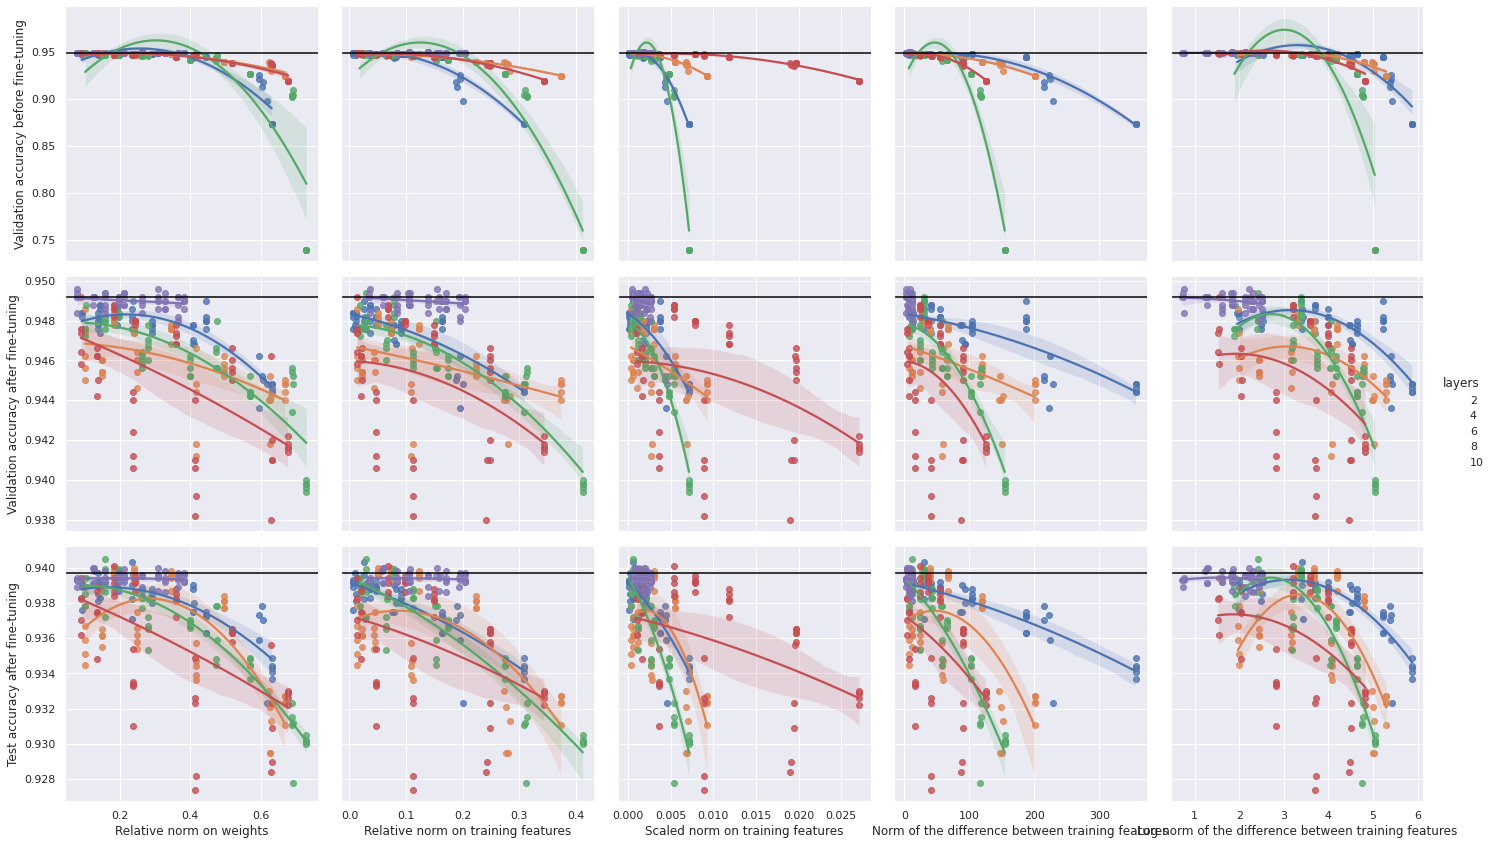

In [119]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff","log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(lambda x, y, **kwargs: sns.regplot(x=x,y=y,order=2)) # sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')
# g.set(ylim=ylim)
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(5):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

# plt.legend(
#     bbox_to_anchor=(1.05, 1,1,1),
#     loc='upper left', borderaxespad=0.
# )
g.savefig("../../plots/fmnist/gar/gar_fm_poly2_errors_performances_layers")

In [176]:
from statsmodels.api import OLS

errors = ['error', 'relative_norm','scaled_norm','norm_diff']
metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_ols = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        res = OLS(df[metric], df[error], hasconst=True).fit()
        print(res.summary())
        # df_kt[error][metric] = (corr, p)

                             OLS Regression Results                            
Dep. Variable:     valid_acc_before_ft   R-squared:                   -1149.942
Model:                             OLS   Adj. R-squared:              -1149.942
Method:                  Least Squares   F-statistic:                       nan
Date:                 Thu, 24 Mar 2022   Prob (F-statistic):                nan
Time:                         14:15:12   Log-Likelihood:                -109.90
No. Observations:                  260   AIC:                             221.8
Df Residuals:                      259   BIC:                             225.4
Df Model:                            0                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
error          1.5496      0.043     36.46

In [101]:



df_pr_layers = pd.DataFrame(
    index=layers,
    columns=errors_metrics,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = pearsonr(df_layer[error], df_layer[metric])
            df_pr_layers[f'{error}-{metric}'][str(layer)] = (corr, p)

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [102]:
df_pr_layers

error-valid_acc_before_ft  \
63                                     (nan, nan)   
60                                     (nan, nan)   
28   (-0.8473943846363547, 8.526029318429482e-15)   
44    (-0.92807967008753, 1.5569321880360468e-13)   
15  (-0.8452560604640299, 4.1808353690622275e-09)   
38    (-0.865389039933643, 6.767629125830957e-10)   
41   (-0.9703158826938701, 8.423955171813325e-19)   
19   (-0.8860065078609245, 7.535093163088947e-11)   

                                  error-valid_acc  \
63      (0.2879151138321128, 0.12286811404521604)   
60      (0.05364974643058675, 0.7782745727113813)   
28     (-0.89963258051531, 6.749407186012029e-19)   
44   (-0.6504162560386235, 9.984548200024738e-05)   
15  (-0.8308757372821841, 1.3206059307718488e-08)   
38   (-0.6776279241263408, 3.895111656379433e-05)   
41  (-0.7495675516016722, 1.8693704254260377e-06)   
19   (-0.9112030273968714, 2.678090326834498e-12)   

                                   error-test_acc  \
63      (0.08140949047449081, 0.6688969781722545)   
60      (-0.202319015036619, 0.28363153595318413)   
28   (-0.8503506557583609, 5.521851294743111e-15)   
44   (-0.40001403206557967, 0.028506973055201903)   
15   (-0.778557370077811, 4.0628161410152266e-07)   
38    (-0.5044203224748514, 0.004476991652362888)   
41   (-0.8643378889684963, 7.495257969083912e-10)   
19  (-0.7977242458237551, 1.3002694977976146e-07)   

                relative_norm-valid_acc_before_ft  \
63                                     (nan, nan)   
60                                     (nan, nan)   
28     (-0.9120220389779395, 3.2969719058788e-20)   
44    (-0.9426384838741954, 7.18649942865184e-15)   
15    (-0.9041877267765982, 7.42816655433022e-12)   
38   (-0.8635795042211782, 8.064108376976551e-10)   
41  (-0.9941407242821838, 1.3281946044565624e-28)   
19   (-0.9543004542805604, 3.206527864443561e-16)   

                          relative_norm-valid_acc  \
63      (0.22660045854936292, 0.2285339296372333)   
60     (-0.07591620160216175, 0.6901010135920719)   
28   (-0.9501238765400875, 6.183917885757045e-26)   
44  (-0.6841285370782828, 3.0657713149688406e-05)   
15     (-0.88880481257465, 5.416616492454828e-11)   
38    (-0.7167802034754958, 8.35639365741935e-06)   
41   (-0.8424403179898148, 5.283717911651034e-09)   
19  (-0.9624158367000015, 2.1833265641118366e-17)   

                          relative_norm-test_acc  \
63     (0.08969793863827741, 0.6373750749423998)   
60     (-0.13347274372940285, 0.481960786929708)   
28  (-0.9094785965290709, 6.345321235786794e-20)   
44  (-0.43789598452890244, 0.015512948579349773)   
15  (-0.8428099291664479, 5.125140529275926e-09)   
38  (-0.48123306693167356, 0.007096860612639137)   
41   (-0.885164202369319, 8.308319981602859e-11)   
19  (-0.875381953010202, 2.4510970789238774e-10)   

                  scaled_norm-valid_acc_before_ft  \
63                                     (nan, nan)   
60                                     (nan, nan)   
28   (-0.9120504145735633, 3.272613774020444e-20)   
44   (-0.9426349991137994, 7.192458046807915e-15)   
15   (-0.9042329237813166, 7.381372629649023e-12)   
38   (-0.8635896750238307, 8.056224123315002e-10)   
41  (-0.9941311159924484, 1.3589347640551856e-28)   
19  (-0.9542604206055397, 3.2452737999364755e-16)   

                            scaled_norm-valid_acc  \
63     (0.22549585148419915, 0.23087130977122738)   
60     (-0.07619222745748086, 0.6890298881252326)   
28   (-0.9501462603759921, 6.119201642748657e-26)   
44   (-0.684144129964898, 3.0639890645477375e-05)   
15   (-0.8888088544663618, 5.414000236015289e-11)   
38   (-0.7167965316315917, 8.350594812939163e-06)   
41  (-0.8424757709014247, 5.2683145963633854e-09)   
19   (-0.9623777391993933, 2.213995204232982e-17)   

                            scaled_norm-test_acc  \
63     (0.08987146559723141, 0.6367214748520443)   
60     (-0.1332129890742588, 0.4828216177381716)   
28  (-0.9095089557688517, 6.296645262386004e-20)   
4